In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
from pathlib import Path 
import warnings
warnings.filterwarnings("ignore")
import pyreadr
import random
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pyreadr.read_r('I80_1st15minutes_complete.rds')
df= df[None]


In [3]:
df.columns

Index(['Vehicle.ID', 'Frame.ID', 'Lane', 'Local.Y', 'svel', 'sacc',
       'Vehicle.Length', 'Vehicle.class', 'Following.Vehicle.ID',
       'Preceding.Vehicle.ID', 'Vehicle.Width.ft', 'PrecVehClass',
       'FollVehClass', 'PrecVehLength', 'FollVehLength', 'lane.change',
       'PrecVehVel', 'PrecVehAcc', 'FollVehVel', 'FollVehAcc', 'Vehicle.type',
       'PrecVehType', 'lanechng', 'PrecVehLocalY', 'FollVehLocalY', 'spacing',
       'headway', 'frspacing', 'entryLane', 'entry', 'LCType', 'dV', 'svelkm',
       'PrecVehVelkm', 'svelkm.level', 'PrecVehVelkm.level', 'dA'],
      dtype='object')

In [4]:
df["Vehicle.ID"]=df["Vehicle.ID"].astype(str)
df["Preceding.Vehicle.ID"]=df["Preceding.Vehicle.ID"].astype(str)
df["LF_pairs"] = df["Preceding.Vehicle.ID"]+ "_"+ df["Vehicle.ID"]

In [5]:
df["nextframeAcc"]=df.groupby(["LF_pairs"],as_index=False)["sacc"].shift(-1)
df["nextframesvel"]=df.groupby(["LF_pairs"],as_index=False)["svel"].shift(-1)
df["nextframeposition"]=df.groupby(["LF_pairs"],as_index=False)["Local.Y"].shift(-1)
df["nextframespace"]=df.groupby(["LF_pairs"],as_index=False)["frspacing"].shift(-1)

In [6]:
df['Pair_Time_Duration']=(df.groupby(['LF_pairs'],as_index=False).cumcount()*0.1) +0.1

In [7]:
df['PrecVehType'] = df['PrecVehType'].map({'Motorcycle': 1, 'Car': 2, 'Heavy-Vehicle': 3})
df['Vehicle.type'] = df['Vehicle.type'].map({'Motorcycle': 1, 'Car': 2, 'Heavy-Vehicle': 3})

In [8]:
df = df[df["PrecVehClass"].notna()]

df = df[df["svel"].notna()]

df = df[df["spacing"].notna()]

df = df[df["frspacing"].notna()]

df = df[df["Local.Y"].notna()]

df = df[df["nextframeAcc"].notna()]

df = df[df["Pair_Time_Duration"].notna()]

df = df[df["nextframeposition"].notna()]

df = df[df["nextframesvel"].notna()]

In [9]:
def training_pairs(data):
    random.seed(2109)
    pairs = data["LF_pairs"].unique()
    pairs = pairs.tolist()
    v = round(len(pairs)*0.7)   
    pairs = random.sample(pairs, v)
    return pairs
my_pairs=training_pairs(df)
#converting the total dataset to 70/30% pair for train and test. 
train = df[df['LF_pairs'].isin(my_pairs)]

test = df[~df['LF_pairs'].isin(my_pairs)]

In [10]:
X_train = train[["frspacing",'PrecVehType','Vehicle.type','dV','svel']]
y_train= train['nextframeAcc']
X_test = test[["frspacing",'PrecVehType','Vehicle.type','dV','svel']]
y_test= test['nextframeAcc']
rf = RandomForestRegressor(n_estimators = 150,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=150, n_jobs=-1)

In [16]:
test.columns

Index(['Vehicle.ID', 'Frame.ID', 'Lane', 'Local.Y', 'svel', 'sacc',
       'Vehicle.Length', 'Vehicle.class', 'Following.Vehicle.ID',
       'Preceding.Vehicle.ID', 'Vehicle.Width.ft', 'PrecVehClass',
       'FollVehClass', 'PrecVehLength', 'FollVehLength', 'lane.change',
       'PrecVehVel', 'PrecVehAcc', 'FollVehVel', 'FollVehAcc', 'Vehicle.type',
       'PrecVehType', 'lanechng', 'PrecVehLocalY', 'FollVehLocalY', 'spacing',
       'headway', 'frspacing', 'entryLane', 'entry', 'LCType', 'dV', 'svelkm',
       'PrecVehVelkm', 'svelkm.level', 'PrecVehVelkm.level', 'dA', 'LF_pairs',
       'nextframeAcc', 'nextframesvel', 'nextframeposition', 'nextframespace',
       'Pair_Time_Duration'],
      dtype='object')

In [19]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['LF_pairs'].unique()
    unique_pairs_df = a.tolist()
    unique_pairs_df = unique_pairs_df[rangefrom:rangeto]
    c= len(a)/30
    return c, unique_pairs_df 


def prediction(test,unique_pairs_df,target_variable,rf,time_frame):
        predicted_df = []
        input_df = pd.DataFrame()
    # unique_pairs_df is the test range
        for i in unique_pairs_df:
    # Q this is the input data frame
            input_df = test[test['LF_pairs']== i]
            vel=np.zeros(input_df.shape[0])
            PrecVehType =  np.zeros(input_df.shape[0])
            FollVehtype = np.zeros(input_df.shape[0])
            spacing = np.zeros(input_df.shape[0])
            dv = np.zeros(input_df.shape[0])
            local_y_subject = np.zeros(input_df.shape[0])
            local_y_preceding = np.zeros(input_df.shape[0])
            pred_acc = np.zeros(input_df.shape[0])
            
        
            #adding first value of the vehicle
            vel[0]=input_df.iloc[0]['svel']
            PrecVehType[0]=input_df.iloc[0]['PrecVehType']
            FollVehtype[0] = input_df.iloc[0]['Vehicle.type']
            spacing[0] = input_df.iloc[0]['frspacing']
            local_y_subject[0]=input_df.iloc[0]['Local.Y']
            local_y_preceding[0]=input_df.iloc[0]['PrecVehLocalY']
            length_previous_vehicle=input_df.iloc[0]['PrecVehLength']        
            dv[0] = input_df.iloc[0]['dV']   
            
        #?? verify this     
            pred_acc[0] = input_df.iloc[1][target_variable]
        
        

    #     #predicting first value of acceleration
                #check here
            pred_acc[1]= rf.predict(np.array([vel[0],PrecVehType[0],FollVehtype[0],dv[0],spacing[0]]).reshape(1,-1))
                

    #     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
                #check here
        
        
            for j in range(1,len(input_df)):
    #         ########
    #         #print(j)
    #         ########
                vel[j] = vel[j-1]+(pred_acc[j-1]*time_frame)
                dv[j] = vel[j] - input_df.iloc[j]['FollVehVel']
               # s = ((vel[j-1]*0.8)+ (0.5*pred_acc[j-1]*pow(0.8,2)))
                #local_y_subject[j]=  local_y_subject[j-1] + s
                #local_y_preceding[j]=  input_df.iloc[j-1]['previous_Local_Y']
                #spacing[j]=local_y_preceding[j] - local_y_subject[j] - input_df.iloc[j-1]['previous_Local_Y'] -length_previous_vehicle
                s = ((vel[j-1]*time_frame)+ (0.5*pred_acc[j-1]*pow(time_frame,2)))
                local_y_subject[j]=  local_y_subject[j-1] + s
                local_y_preceding[j]=  input_df.iloc[j]['PrecVehLocalY']
                spacing[j]=local_y_preceding[j] - local_y_subject[j]-length_previous_vehicle
                PrecVehType[j]= PrecVehType[j-1]
                FollVehtype[j]=FollVehtype[j-1]
    #         ########
    #         ## localy: s = ut + 0.5*a*t^2
    #         ########
                
                if j == len(input_df)-1:
                    break
                pred_acc[j+1] = rf.predict(np.array([PrecVehType[j],FollVehtype[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
    #         ########
    #         #print(pred_acc)
    #         ########
            input_df['pacc']=pred_acc
            input_df['pvel']=vel
            input_df['pspace']=spacing
            input_df['pvel']=vel
            predicted_df.append(input_df)
            result = pd.concat(predicted_df)
            #r.append(r2_score(Q[target_variable], Q['pacc']))      
            return result


In [20]:
c, unique_pairs_df = data_in_parts(test,0,6)
print(unique_pairs_df)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test, ['15_13'], target_variable, rf,0.1)

['3355_1', '17_12', '15_13', '27_31', '25_39', '13_41']


In [56]:
test[test["LF_pairs"]=="15_13"].isnull().sum()

Vehicle.ID               0
Frame.ID                 0
Lane                     0
Local.Y                  0
svel                     0
sacc                     0
Vehicle.Length           0
Vehicle.class            0
Following.Vehicle.ID     0
Preceding.Vehicle.ID     0
Vehicle.Width.ft         0
PrecVehClass             0
FollVehClass            52
PrecVehLength            0
FollVehLength           52
lane.change              0
PrecVehVel               0
PrecVehAcc               0
FollVehVel              52
FollVehAcc              52
Vehicle.type             0
PrecVehType              0
lanechng                 0
PrecVehLocalY            0
FollVehLocalY           52
spacing                  0
headway                  0
frspacing                0
entryLane                0
entry                    0
LCType                   0
dV                       0
svelkm                   0
PrecVehVelkm             0
svelkm.level             0
PrecVehVelkm.level       0
dA                       0
L

In [13]:
test = test[test["FollVehVel"].notna()]

In [23]:
F.to_excel("r.xlsx")

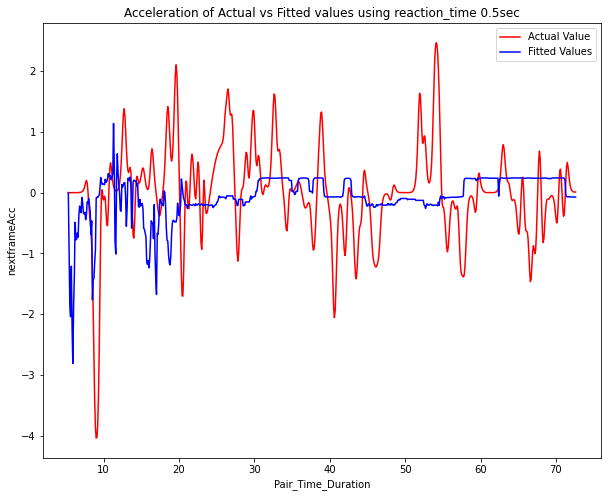

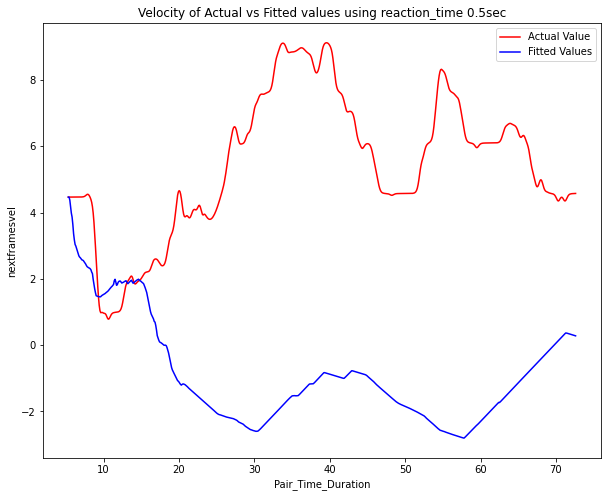

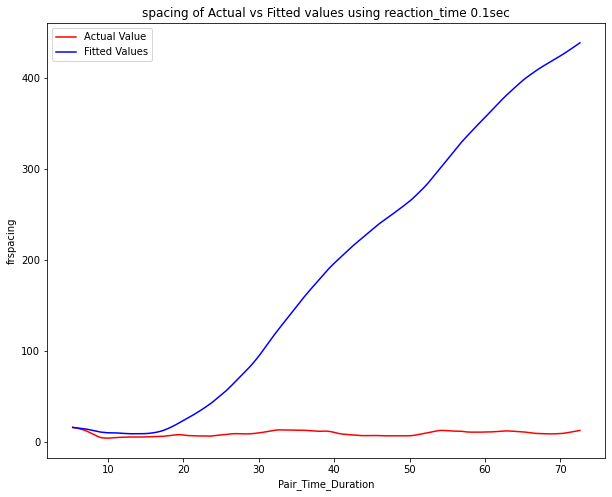

<module 'matplotlib.pyplot' from 'c:\\Users\\neels\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [21]:
import RFmodel
model = RFmodel.ModelClass()  
F1 = F[F["LF_pairs"] == "15_13"]
model.plot_1(F1,'nextframeAcc','pacc','Acceleration of Actual vs Fitted values using reaction_time 0.5sec')
model.plot_1(F1,'nextframesvel','pvel', 'Velocity of Actual vs Fitted values using reaction_time 0.5sec')
model.plot_1(F1,'frspacing','pspace', 'spacing of Actual vs Fitted values using reaction_time 0.1sec')

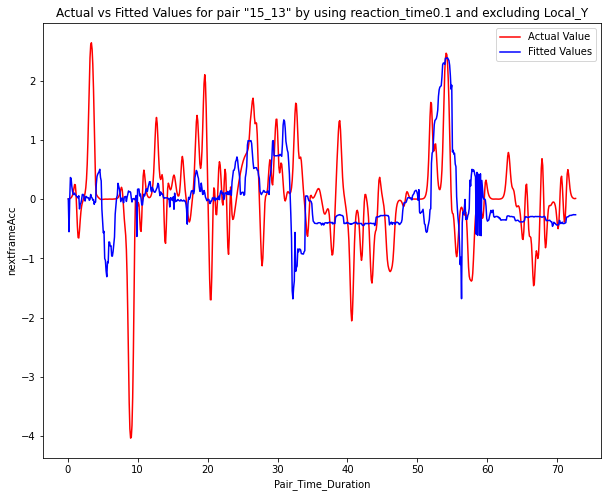

In [21]:
import seaborn as sns
plt.figure(figsize=(10, 8))


ax = sns.lineplot(x=F1["Pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["Pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values for pair "15_13" by using reaction_time0.1 and excluding Local_Y')


plt.show()
plt.close()

In [16]:
def accuracy(F):
    mae_score = mean_absolute_error(F['sacc'], F['pacc'])
    r2_scores = r2_score(F['sacc'], F['pacc'])
    return mae_score, r2_scores

In [19]:
accuracy(F)

(0.7604026008551992, -0.25026994751800813)

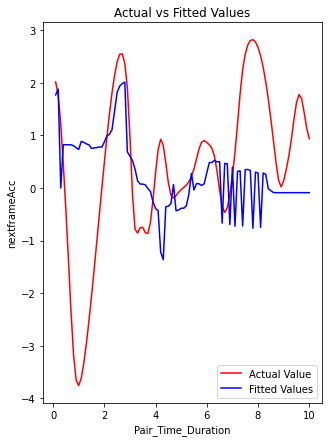

In [63]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F2["Pair_Time_Duration"], y = F2["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F2["Pair_Time_Duration"], y =F2["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [71]:
F0 = F[F["LF_pairs"] == "3355_1"]

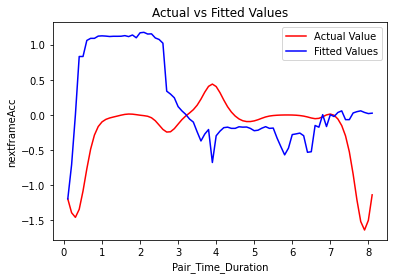

In [72]:
ax = sns.lineplot(x=F0["Pair_Time_Duration"], y = F0["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F0["Pair_Time_Duration"], y =F0["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [81]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['LF_pairs'].unique()
    b = a.tolist()
    b = b[rangefrom:rangeto]
    c= len(a)/30
    return c,b 


def prediction(test,b,target_variable,RFReg):
    F_df = []
    r = []
    Q = pd.DataFrame()
# b is the test range
    for i in b:
# Q this is the input data frame
        Q = test[test['LF_pairs']== i]
        vel=np.zeros(Q.shape[0])
        PrecVehType =  np.zeros(Q.shape[0])
        FollVehtype = np.zeros(Q.shape[0])
        spacing = np.zeros(Q.shape[0])
        dv = np.zeros(Q.shape[0])
        pred_acc = np.zeros(Q.shape[0])
        
    
        #adding first value of the vehicle
        vel[0]=Q.iloc[0]['svel']
        PrecVehType[0]=Q.iloc[0]['PrecVehType']
        FollVehtype[0] = Q.iloc[0]['Vehicle.type']
        spacing[0] = Q.iloc[0]['spacing']
        
        dv[0] = Q.iloc[0]['dV']   
        #pred_speed[0] = Q.iloc[0]['svel']
    #?? verify this     
        pred_acc[0] = Q.iloc[1][target_variable]
     
    

#     #predicting first value of acceleration
            #check here
        pred_acc[1]= rf.predict(np.array([vel[0],PrecVehType[0],FollVehtype[0],dv[0],spacing[0]]).reshape(1,-1))
            

#     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
            #check here
    
    
        for j in range(2,len(Q)):
#         ########
#         #print(j)
#         ########
            vel[j] = vel[j-1]+(pred_acc[j]*0.1)
            dv[j] = vel[j] - Q.iloc[j]['PrecVehVel']
            spacing[j] = ((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2))) ############################################################
            PrecVehType[j]= PrecVehType[j-1]
            FollVehtype[j]=FollVehtype[j-1]
#         ########
#         ## localy: s = ut + 0.5*a*t^2
#         ########
            
            if j == len(Q)-1:
                break
            pred_acc[j+1] = rf.predict(np.array([PrecVehType[j],FollVehtype[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
#         ########
#         #print(pred_acc)
#         ########
        Q['pacc1']=pred_acc

        F_df.append(Q)
        result = pd.concat(F_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))
        
 
    return result


In [87]:
c, b = data_in_parts(test,0,5)
print(b)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test, b, target_variable, rf)

['3355_1', '17_12', '15_13', '27_31', '25_39']


In [92]:
F["LF_pairs"].unique()

array(['3355_1', '17_12', '15_13', '27_31', '25_39'], dtype=object)

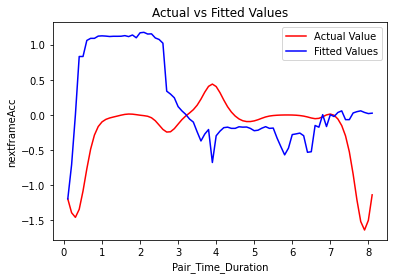

In [83]:
ax = sns.lineplot(x=F0["Pair_Time_Duration"], y = F0["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F0["Pair_Time_Duration"], y =F0["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [93]:
F00 = F[F["LF_pairs"] == "15_13"]

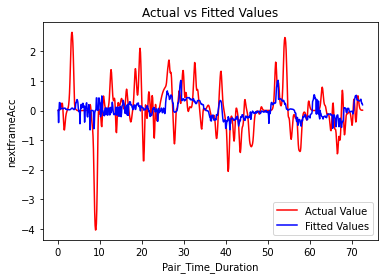

In [94]:
ax = sns.lineplot(x=F00["Pair_Time_Duration"], y = F00["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F00["Pair_Time_Duration"], y =F00["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()